In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
import json
import math

keras.config.enable_unsafe_deserialization()

In [6]:
def get_model_acc(X1, X2, y, model_type, model=None, model_pro=None, threshold1 = 0, threshold2 = 0):
    if model_type == "single":
        y1 = model.predict(X1)
        y2 = model.predict(X2)
        y_pred = np.where(np.abs(y1 - y2) < threshold1, 0, np.where(y1 > y2, 1, 2))
        y_combined = np.hstack([y1, y2])
        y_pred_pro = np.argmax(model_pro.predict(y_combined), axis=1)
        return accuracy_score(y, y_pred), accuracy_score(y, y_pred_pro)
    
    elif model_type == "regression":
        y_pred = model.predict([X1, X2])
        y_pred = np.where(y_pred > threshold2, 2, np.where(y_pred < threshold1, 1, 0))
        y_pred_pro = np.argmax(model_pro.predict(y_pred), axis=1)
        return accuracy_score(y, y_pred), accuracy_score(y, y_pred_pro)
    
    elif model_type == "classification":
        y_pred = np.argmax(model.predict([X1, X2]), axis=1)
        return confusion_matrix(y, y_pred), accuracy_score(y, y_pred)

In [7]:
endgames = ['KRK', 'KPK']
model_types = ["single", "regression", "classification"]
cm = {}
accuracies = {}

#with open(r"C:\SPEICHER\Bachelor_Thesis\Configs\thresholds.json", "r") as f:
#    threshold_config = json.load(f)

for endgame in endgames:
    accuracies[endgame] = {}
    data = np.load(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\{endgame}_position_Double.npz")
    positions, dtm_values = data["X"], data["y"]
    data = np.load(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\{endgame}_pairs_Double.npz")
    X1, X2, y = data["X1"], data["X2"], data["y"]
    temp_hist_list = []
    for model_type in model_types:
        model = keras.models.load_model(fr"C:\SPEICHER\Bachelor_Thesis\Models\{endgame}_model_{model_type}.keras")
        if not model_type == "classification":
            model_pro = keras.models.load_model(fr"C:\SPEICHER\Bachelor_Thesis\Models\{endgame}_model_pro_{model_type}.keras")
        
        threshold1, threshold2 = 0,0 #threshold_config[endgame][model_type]["threshold1"], threshold_config[endgame][model_type]["threshold2"]
        model_acc, model_pro_acc = get_model_acc(X1, X2, y, model_type, model, model_pro if not model_type=="Classification" else None, threshold1=threshold1, threshold2=threshold2)
        if model_type == "classification":
            cm[endgame] = model_acc
            accuracies[endgame][model_type] = model_pro_acc
        else:
            accuracies[endgame][model_type] = (model_acc, model_pro_acc)


15625/15625 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 12s 782us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 13s 797us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 14s 863us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 11s 687us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step


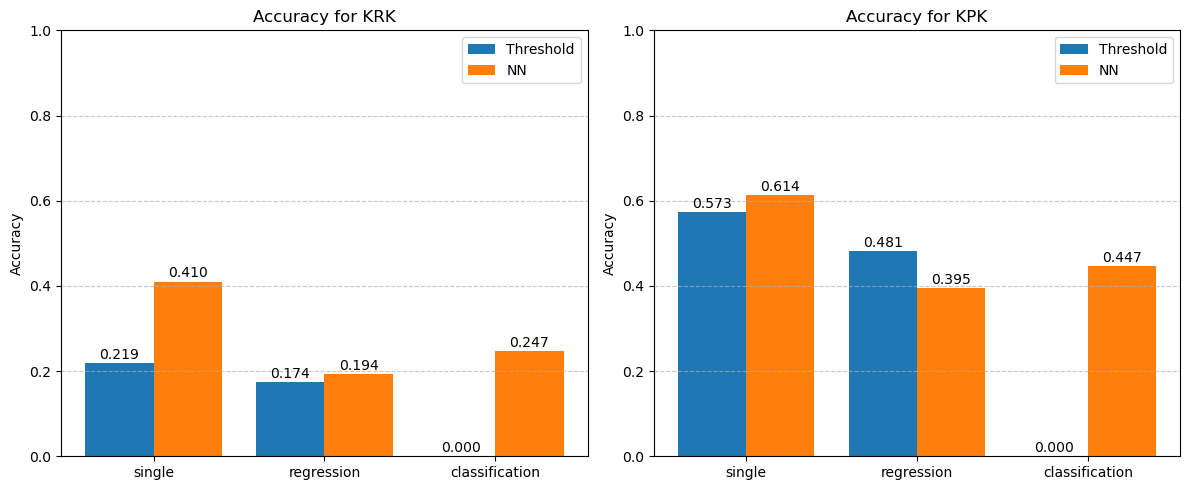

In [9]:
fig, axes = plt.subplots(1, len(endgames), figsize=(6 * len(endgames), 5))

if len(endgames) == 1:
    axes = [axes]  # ensure it's iterable

for idx, endgame in enumerate(endgames):
    ax = axes[idx]
    model_names = []
    accuracy_scores = []
    pro_accuracy_scores = []

    for i, model_type in enumerate(model_types):
        acc_pair = accuracies[endgame][model_type]
        model_names.append(model_type)
        if type(acc_pair) is tuple:
            pro_accuracy_scores.append(acc_pair[1])
            accuracy_scores.append(acc_pair[0])
        else:
            accuracy_scores.append(0)
            pro_accuracy_scores.append(acc_pair)
        

    x = range(len(model_names))
    ax.bar(x, accuracy_scores, width=0.4, label="Threshold", align='center')
    ax.bar([i + 0.4 for i in x], pro_accuracy_scores, width=0.4, label="NN", align='center')

    ax.set_xticks([i + 0.2 for i in x])
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 1)
    ax.set_title(f"Accuracy for {endgame}")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for j in range(len(model_names)):
        ax.text(j, accuracy_scores[j] + 0.01, f'{accuracy_scores[j]:.3f}', ha='center')
        ax.text(j + 0.4, pro_accuracy_scores[j] + 0.01, f'{pro_accuracy_scores[j]:.3f}', ha='center')

plt.tight_layout()
plt.show()